#### Essayer d'apprendre les paramètres du ressort à partir des descripteurs des signaux pour avoir des coefs d'importance pour les descripteurs (poids à mettre pour le calcul des distance)

**Plan du notebook:**

**1.** Coefficients de corrélation

**2.** Régression linéaire pour apprendre les paramètres `F` et/ou `k` (ou SVM linéaire)

**3.** Analyse en composante principales

**4.** Autres méthodes de machine learning (SVM, tree) qui ont un paramètre `coef_` ou `feature_importance_`. Ce paramètre n'est pas simplement interprétable mais permet d'avoir une idée de l'importance relative des descripteurs si 2. donne de trop mauvais résultats

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

import simu_ressort
import descriptor

In [2]:
names_desc = ['mean', 'std', 'min', 'max', 'fr_max', 'ampl_max', 'spectral centroid',
              'spectral width', 'spectral platitude']

In [3]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

print("{} descripteurs pour chaque simu".format(len(descriptor.compute_descriptor([1, 2]))))

81 parameters tested, and 200 simus for each parameter.
The duration of each simu is 1000 dt.
9 descripteurs pour chaque simu


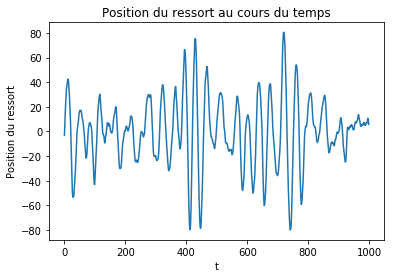

Descripteurs: [  2.02968818e-01   2.75933904e+01  -7.99473432e+01   8.05270474e+01
   2.40000000e-02   7.62580707e+03  -1.43882735e-05   8.28794578e-02
   1.49236472e+01]


In [4]:
i = 20
V = all_simus[25]['simu'][i, :]
simu_ressort.plot_ressort(V)
desc = descriptor.compute_descriptor(V)
print("Descripteurs:", desc)

In [5]:
def test_corr(nb_param):
    desc = []
    for j in range(nb_param):
        for i in range(100):
            V = all_simus[j]['simu'][i, :]
            desc.append(descriptor.compute_descriptor(V))

    desc = np.array(desc)
    print(desc.shape)
    
    print(np.corrcoef(desc[:, 0], desc[:, 1]))

In [6]:
test_corr(nb_param=80)

(8000, 9)
[[ 1.         -0.04947963]
 [-0.04947963  1.        ]]


In [7]:
test_corr(nb_param=81)

(8100, 9)
[[ 1.        -0.0491424]
 [-0.0491424  1.       ]]


Le 100ème jeu de paramètres (1, 1) semble poser problème mais alors je ne comprends pas du tout pourquoi....

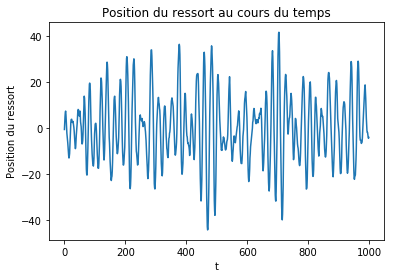

In [8]:
V = all_simus[80]['simu'][i, :]
simu_ressort.plot_ressort(V)

### Preprocess data

In [9]:
nb_desc = len(descriptor.compute_descriptor([0]))
nb_simus = len(all_simus) * len(all_simus[0]['simu'])
print("{} descriptors and {} signals".format(nb_desc, nb_simus))

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)


9 descriptors and 16200 signals


In [10]:
def preprocess_simu_to_numpy(all_simus):

    X_data = []
    Y_data = []

    for i in range(len(all_simus)):
        for j in range(len(all_simus[i]['simu'])):
            X_data.append(descriptor.compute_descriptor(all_simus[i]['simu'][j, :]))
            Y_data.append([all_simus[i]['F'], all_simus[i]['k']])
            
    return np.array(X_data), np.array(Y_data)

In [11]:
def separate_test_train(X_data, Y_data, pct_train=0.8):
    n_train = int(pct_train * len(X_data))
    
    X_train = X_data[:n_train, :]
    X_test = X_data[n_train:, :]    
    Y_train = Y_data[:n_train, :]    
    Y_test = Y_data[n_train:, :]
    
    return X_train, X_test, Y_train, Y_test

In [12]:
X_data, Y_data = preprocess_simu_to_numpy(all_simus)

# Mettre les variables à la même écheller
#X_data = StandardScaler().fit_transform(X_data)

print("Shape of X_data: {} and Y_data: {}".format(np.shape(X_data), np.shape(Y_data)))

X_train, X_test, Y_train, Y_test = separate_test_train(X_data, Y_data, pct_train=0.8)

Shape of X_data: (16200, 9) and Y_data: (16200, 2)


In [13]:
# Transformer en DataFrame juste pour faire plus beau pour les coef de corr

X_df = pd.DataFrame(X_data)
X_df.columns = names_desc

# Ajouter les variables F et k
X_df['F'] = Y_data[:, 0]
X_df['k'] = Y_data[:, 1]

X_df.describe()

,mean,std,min,max,fr_max,ampl_max,spectral centroid,spectral width,spectral platitude,F,k
count,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,1.620000e+04,16200.000000,16200.000000,16200.000000,16200.000000
mean,-0.012408,43.794420,-112.244071,112.102267,0.017792,20287.784365,-3.696320e-05,0.097795,10.705238,0.500000,0.500000
std,1.590700,29.681194,64.914976,64.798311,0.029009,18066.480644,2.569809e-05,0.016649,5.391569,0.258207,0.258207
min,-12.571379,11.358823,-788.772862,32.259285,-0.052000,2568.914909,-1.576746e-04,0.043856,2.713911,0.100000,0.100000
25%,-0.578836,24.398318,-134.060429,69.248401,0.015000,8850.157398,-5.393215e-05,0.086821,7.241882,0.300000,0.300000
50%,-0.002625,34.644716,-93.626671,93.776871,0.030000,14334.257345,-3.301254e-05,0.097585,9.351145,0.500000,0.500000
75%,0.573774,52.841233,-69.561065,133.311518,0.040000,25254.008203,-1.578344e-05,0.108090,12.603956,0.700000,0.700000
max,12.790643,340.014095,-26.286333,789.946791,0.053000,201351.213967,-3.867183e-10,0.149920,53.319187,0.900000,0.900000


## 1. Coefficients de corrélation

In [14]:
X_df.corr()

,mean,std,min,max,fr_max,ampl_max,spectral centroid,spectral width,spectral platitude,F,k
mean,1.000000,-0.006481,0.031781,0.019317,0.007339,-0.007023,0.012579,-0.007294,0.005712,1.320954e-02,8.290246e-03
std,-0.006481,1.000000,-0.967897,0.968172,-0.017791,0.976521,-0.152783,-0.034011,0.223906,-5.812865e-01,-4.723082e-01
min,0.031781,-0.967897,1.000000,-0.977394,0.025826,-0.926407,0.156320,0.032525,-0.232967,5.570999e-01,4.909341e-01
max,0.019317,0.968172,-0.977394,1.000000,-0.026154,0.926423,-0.156122,-0.032179,0.233309,-5.536749e-01,-4.893228e-01
fr_max,0.007339,-0.017791,0.025826,-0.026154,1.000000,0.015294,-0.015431,0.075320,-0.103348,-8.256606e-02,1.999590e-01
ampl_max,-0.007023,0.976521,-0.926407,0.926423,0.015294,1.000000,-0.164636,0.013945,0.151014,-6.121231e-01,-3.635294e-01
spectral centroid,0.012579,-0.152783,0.156320,-0.156122,-0.015431,-0.164636,1.000000,-0.665859,0.514479,1.918547e-01,-6.153038e-02
spectral width,-0.007294,-0.034011,0.032525,-0.032179,0.075320,0.013945,-0.665859,1.000000,-0.891880,-7.485650e-02,3.696786e-01
spectral platitude,0.005712,0.223906,-0.232967,0.233309,-0.103348,0.151014,0.514479,-0.891880,1.000000,2.646507e-02,-5.439912e-01
F,0.013210,-0.581286,0.557100,-0.553675,-0.082566,-0.612123,0.191855,-0.074857,0.026465,1.000000e+00,-1.320960e-15


In [15]:
X_df.corr()[['F', 'k']]

,F,k
mean,1.320954e-02,8.290246e-03
std,-5.812865e-01,-4.723082e-01
min,5.570999e-01,4.909341e-01
max,-5.536749e-01,-4.893228e-01
fr_max,-8.256606e-02,1.999590e-01
ampl_max,-6.121231e-01,-3.635294e-01
spectral centroid,1.918547e-01,-6.153038e-02
spectral width,-7.485650e-02,3.696786e-01
spectral platitude,2.646507e-02,-5.439912e-01
F,1.000000e+00,-1.320960e-15


`F` et `k` fortement corrélés à `spectrak width`mais également à `spectral platitude` et `spectral centroid`

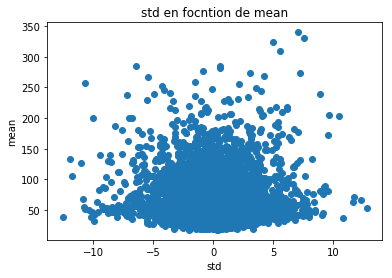

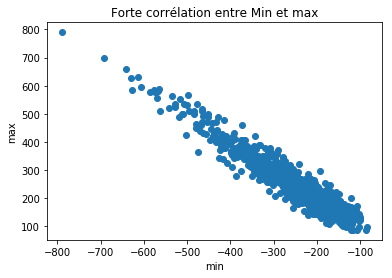

In [16]:
plt.scatter(X_data[:7000, 0], X_data[:7000, 1])
plt.title('std en focntion de mean')
plt.xlabel('std')
plt.ylabel('mean')
plt.show()

plt.scatter(X_data[:1000, 2], X_data[:1000, 3])
plt.title('Forte corrélation entre Min et max')
plt.xlabel('min')
plt.ylabel('max')
plt.show()

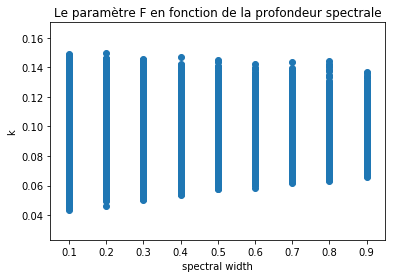

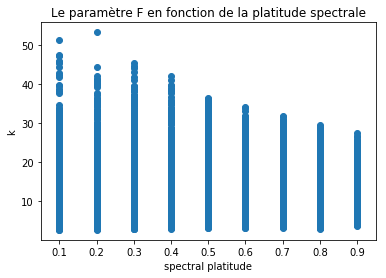

In [17]:
plt.scatter(Y_data[:, 0], X_data[:, 7])
plt.title('Le paramètre F en fonction de la profondeur spectrale')
plt.xlabel('spectral width')
plt.ylabel('k')
plt.show()

plt.scatter(Y_data[:, 0], X_data[:, 8])
plt.title('Le paramètre F en fonction de la platitude spectrale')
plt.xlabel('spectral platitude')
plt.ylabel('k')
plt.show()

## 2. Apprendre `(F, k)` avec une regression linéaire
Pour trouver les poids des descripteurs

In [18]:
def train_regr_lin(X_train, Y_train, X_test, Y_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)

    y_pred = regr.predict(X_test)
    print("MSE on test set:", mean_squared_error(y_pred, Y_test))
    
    return regr

In [19]:
_ = train_regr_lin(X_train, Y_train, X_test, Y_test)

MSE on test set: 0.0669645940425


-> L'erreur est assez variable selon le jeu de données et j'ai du mal à voir pourquoi

#### Prédiction de `F`

In [20]:
regr_f = train_regr_lin(X_train, Y_train[:, 0], X_test, Y_test[:, 0])

MSE on test set: 0.0371064469291


In [21]:
regr_f.coef_

array([  1.10088417e-03,   4.45086952e-03,   8.53278276e-04,
        -3.25802404e-04,  -5.28028086e-01,  -1.18844530e-05,
         1.46985185e+03,   4.99990060e+00,   1.48480827e-02])

In [22]:
names_desc

['mean',
 'std',
 'min',
 'max',
 'fr_max',
 'ampl_max',
 'spectral centroid',
 'spectral width',
 'spectral platitude']

In [23]:
def normalize_coef(coefs, seuil=0.0001):
    #  Normalize coefs
    coefs = sklearn.preprocessing.normalize([coefs])

    coefs_dico = {}
    for i in range(len(coefs[0])):
        coefs_dico[names_desc[i]] = coefs[0][i] if coefs[0][i] > seuil else 0
        
    coefs_treated = [x if x > seuil else 0 for x in coefs[0]]
    # Normalize à nouveau
    coefs_treated = sklearn.preprocessing.normalize([coefs_treated])
    
    return coefs_dico, coefs_treated
    
coefs_dico, coefs_treated = normalize_coef(regr_f.coef_)
print(coefs_treated)
coefs_dico

[[ 0.          0.          0.          0.          0.          0.
   0.99999421  0.00340162  0.        ]]


{'ampl_max': 0,
 'fr_max': 0,
 'max': 0,
 'mean': 0,
 'min': 0,
 'spectral centroid': 0.99999414990605873,
 'spectral platitude': 0,
 'spectral width': 0.0034016158454299185,
 'std': 0}

In [24]:
regr_f.intercept_  # Zero à l'origin

0.096479235857845902

#### Prédiction de `k`

In [25]:
_ = train_regr_lin(X_train, Y_train[:, 1], X_test, Y_test[:, 1])

MSE on test set: 0.0968227411559


#### Prediction de `F` avec normalisation

In [26]:
from sklearn import preprocessing

# Normalize data
scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = preprocessing.scale(X_data)

X_train_sc, X_test_sc, Y_train_sc, Y_test_sc = separate_test_train(
    X_scaled, Y_data, pct_train=0.8)

In [27]:
regr_f_sc = train_regr_lin(X_train_sc, Y_train_sc[:, 0], X_test_sc, Y_test_sc[:, 0])

MSE on test set: 0.0371064469291


In [28]:
coefs_dico_sc, coefs_treated_sc = normalize_coef(regr_f_sc.coef_)
print(coefs_treated_sc)
coefs_dico_sc

[[ 0.00932206  0.70324713  0.294861    0.          0.          0.
   0.20107407  0.44314215  0.42615468]]


{'ampl_max': 0,
 'fr_max': 0,
 'max': 0,
 'mean': 0.0061127814442162049,
 'min': 0.19335014618348587,
 'spectral centroid': 0.13185094430224206,
 'spectral platitude': 0.27944376830796497,
 'spectral width': 0.29058302203644637,
 'std': 0.46114249334123469}

Les coef changent complètement mais le MSE est identique -> les

## 3. ACP

In [29]:
from sklearn.decomposition import PCA

In [30]:
from sklearn import preprocessing

# Normalize data

scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = preprocessing.scale(X_data)

#### Projection en 2D

In [31]:
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data=principal_comp, columns=['principal component 1', 'principal component 2'])
principal_df['target'] = Y_data[:, 0]

In [32]:
x = pca.explained_variance_ratio_
print(x)
print("La premiere composante principale explique {}% de la variance des données".format(round(x[0] * 100, 2)))

[ 0.4396434  0.2663543]
La premiere composante principale explique 43.96% de la variance des données


In [33]:
pca.components_

array([[-0.00429563,  0.49888374, -0.49427933,  0.49426663, -0.01479806,
         0.48539847, -0.07116526, -0.04115294,  0.14105419],
       [ 0.01055354, -0.0288108 ,  0.02641443, -0.02614386, -0.08090453,
        -0.06177328,  0.52377637, -0.6191926 ,  0.57408596]])

-> Coordonnées des premières et deuxiemes composantes principales dans l'espace des descripteurs

ACP pour faire de la réduction de dimension: projetter sur un certains nb de composantes principales (nb < au nb de coord)

**Problème de l'ACP:** la moyenne, variance, etc... sont les variables qui permettent le mieux d'"étaler" les points alors qu'elles ne sont pas pertinentes ici, car le but est de classifier en fonction de F et k

-> Utile en non supervisé lorque l'on a vraiment aucune idée de ce que l'on cherche

## 4. SVM

In [39]:
from sklearn.svm import SVR, LinearSVR

In [40]:
clf = SVR()

clf.fit(X_train, Y_train[:, 0])

Y_pred = clf.predict(X_test)
print("MSE on F:", mean_squared_error(Y_pred, Y_test[:, 0]))

MSE on F: 0.0596559105365


In [ ]:
# Linear kernel to get the coefs (like Linear Regression)

clf = LinearSVR()

clf.fit(X_train, Y_train[:, 0])

Y_pred = clf.predict(X_test)
print("MSE on F:", mean_squared_error(Y_pred, Y_test[:, 0]))

In [ ]:
clf.coef_

## 5. Tree

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train[:, 0])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [42]:
y_pred = tree.predict(X_test)
print("MSE on F for regressor tree:", mean_squared_error(y_pred, Y_test[:, 0]))

MSE on F for regressor tree: 0.053787037037


In [43]:
tree.feature_importances_

array([ 0.02550945,  0.04733323,  0.02375968,  0.02348455,  0.149926  ,
        0.5886554 ,  0.02568663,  0.06820698,  0.0474381 ])

## XGBoost, autre, ...